In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


In [3]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=8

In [4]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('../input/gender-dataset/Dataset/Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )     

validation_generator =  test_datagen.flow_from_directory( '../input/gender-dataset/Dataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [5]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")

58892288/58889256 [==============================] - 3s 0us/step


In [6]:
# Freezing Layers

for layer in base_model.layers[:fre]:
    layer.trainable=False

In [7]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 512)         2359808   
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 512)         2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 128)         589952    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 128)         5

In [8]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

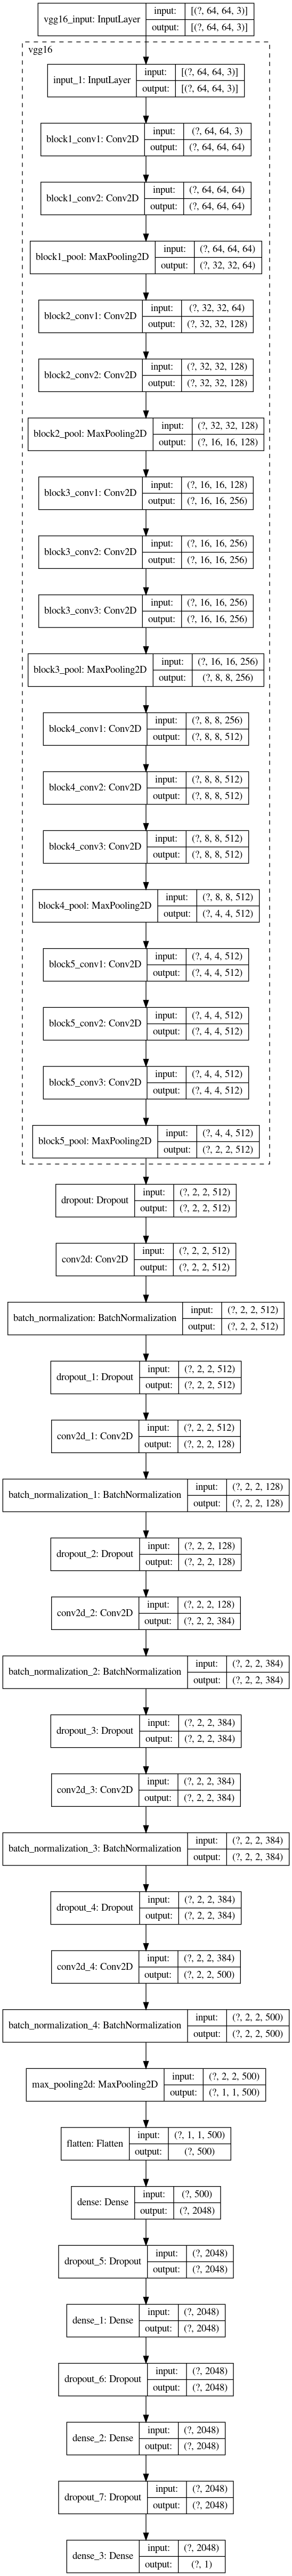

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [10]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

In [ ]:
%time
hist = model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs
Epoch 1/8
256/256 [==============================] - 2089s 8s/step - loss: 0.6726 - accuracy: 0.6586 - val_loss: 0.4590 - val_accuracy: 0.7849
Epoch 2/8
 88/256 [=========>....................] - ETA: 18:34 - loss: 0.4649 - accuracy: 0.7843

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
import numpy as np

from keras.preprocessing import image
#  images test 1
path_testmodel = "../input/testmodel/test1.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]<0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

In [ ]:
import numpy as np

from keras.preprocessing import image
#  images test 2
path_testmodel = "../input/testmodel/test2.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]>0.5:
    print("This is a male")
else:
    print( "This is a female")
plt.imshow(imge)